  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_61012/161835095.py:68: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u, v = random.sample(possible_nodes, 2)


0.6996327669338686
0.5543314646382751


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


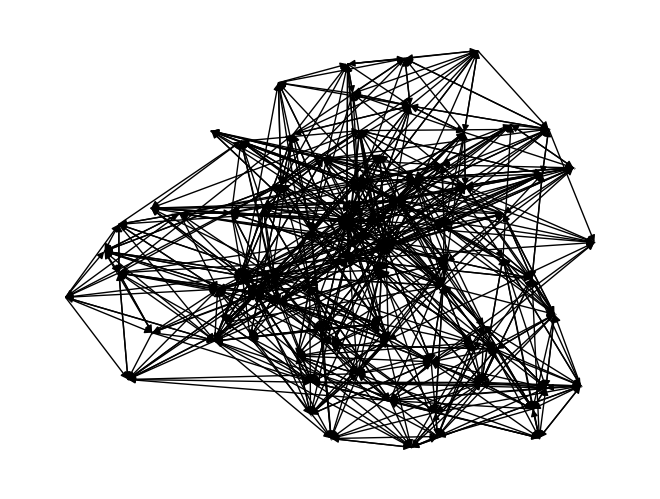

In [6]:
# Reference taken from http://syspedia.de/EgoNetworks/Ego-centric%20graphs.pdf
# An ego-centric approach to synthesize more realistic social networks
# Author: Hans-Peter Stricker

# %%
import pickle
import random
from itertools import chain, combinations
from operator import itemgetter
from statistics import mean

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from tqdm import tqdm

import config
from network import get_network_stats, modify_reciprocity


def clamp(val, lower, upper):
    if val <= lower:
        val = lower
    elif val > upper:
        val = upper
    return val


def get_largest_hub(G):
    node_and_degree = G.degree()
    (largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
    return largest_hub


def powerset_of_2(iterable):
    "powerset_of_2([(),(1),(1,2),(1,2,3)]) --> [(1,2)]"
    s = list(iterable)
    powerset = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    powerset_of_2 = [s for s in powerset if len(s) == 2]
    return powerset_of_2


def get_unique_edges(edges):
    #  return list(set([(u, v) if u <= v else (v, u) for u, v in edges]))
    return list(set([(u, v) if u <= v else (v, u) for u, v in edges]))


def set_new_edges(new_nodes, e1, ego_net: nx.Graph, d, rho):

    possible_nodes = new_nodes
    possible_nodes.extend(n for n in nx.all_neighbors(ego_net, e1))
    possible_nodes = set(possible_nodes)
    '''
    The number of these edges is given by the
    required density of N(e1), i.e. d * (d - 1) * rho/2 - |E(N(e1))|

    where |E(N(e1))| is the number
    of edges between the neighbours of e1, which initially lie completely in N (e0).
    '''

    neighbors_of_e1 = list(nx.all_neighbors(ego_net, e1))

    ENe1 = ego_net.subgraph(neighbors_of_e1).edges()

    num_set_edges = int(d * (d-1) * rho // 2 - len(ENe1))

    for _ in range(num_set_edges):
        u, v = random.sample(possible_nodes, 2)
        ego_net.add_edge(u, v)
    
        


def get_incomplete_nodes(ego_net, d):
    incomplete_nodes = [n for n in ego_net.nodes() if ego_net.degree[n] < d]
    return incomplete_nodes


def sample_new_ego(ego_net, d):
    '''
    Get a random ego node that has not yet reached the defined degree of "d"
    '''
    # The nodes that have not reached the defined degree yet
    incomplete_nodes = get_incomplete_nodes(ego_net, d)
    # The ego node of the current iteration
    e1 = random.choice(incomplete_nodes)
    return e1


def create_new_nodes(ego_net, num_missing_nodes, e1):
    new_nodes = []

    for _ in range(num_missing_nodes):
        new_node = ego_net.number_of_nodes()
        ego_net.add_node(new_node)
        ego_net.add_edge(new_node, e1)
        new_nodes.extend([new_node])

    return new_nodes


def get_qualified_nodes(ego_net, d, e1):
    e1_ego_net = nx.ego_graph(ego_net, e1)
    
    unqualified_nodes = e1_ego_net.nodes()
    qualified_nodes = [n for n in ego_net.nodes() if
                       (n not in unqualified_nodes) and (ego_net.degree(n) < d)]

    return qualified_nodes


def show_network(ego_net):
    # Seed layout for reproducibility
    pos = nx.spring_layout(ego_net)
    # Draw graph
    nx.draw(ego_net, pos, node_color="black", node_size=0.1, with_labels=False)


# Network generation config
d = 10
rho = 0.9
# seed_list = range(10)

# increase_steps = 400
# decrease_steps = 200


seed_list = [1]

increase_steps = 10
decrease_steps = 20



# Network generation process

'''
The general procedure is to start with a random ego-network N (e0 ) with d and ρ taken
from the probability distributions (the “seed network”).
'''

for seed in tqdm(seed_list):
    ego_net = nx.erdos_renyi_graph(d,rho, seed=seed)
    # find node with largest degree
    e0 = get_largest_hub(ego_net)

    '''
    with all nodes additionally
    linked to e0.
    '''
    for n in ego_net.nodes():
        if n != e0:
            ego_net.add_edge(n, e0)

    mapping = {old: new for old, new in zip(
        ego_net.nodes(), range(ego_net.number_of_nodes()))}
    ego_net = nx.relabel_nodes(ego_net, mapping)

    '''
    The next ego-network N (e1) is created by picking an e1 ∈ N (e0) at
    random, checking the number of missing edges d − d(e1) and adding as many new nodes
    from scratch. These then have to be linked at random with each other and with those
    nodes in N (e0 ) that are neighbours of e1.
    '''

    # ---------------------------------------------------------------------------
    #                            1. Increase step
    # ---------------------------------------------------------------------------

    step = 0
    while step < increase_steps:

        e1 = sample_new_ego(ego_net, d)

        num_missing_nodes = d - ego_net.degree[e1]

        new_nodes = create_new_nodes(ego_net, num_missing_nodes, e1)

        set_new_edges(new_nodes, e1, ego_net, d, rho)

        e0 = e1
        step += 1

    print(nx.average_clustering(ego_net))
    
    
    # ---------------------------------------------------------------------------
    #                            2. Decrease step
    # ---------------------------------------------------------------------------

    step = 0
    while step < decrease_steps:
        e1 = sample_new_ego(ego_net, d)

        num_missing_nodes = d - ego_net.degree[e1]

        '''
        During the decrease stage, we reduce the amount of new nodes,
        while taking the rest from the exisiting nodes, conforming to 2 restrictions
        '''
        num_new_nodes = round((1 - step/decrease_steps) * num_missing_nodes)

        # The nodes newly created combined with the existing nodes qualified
        new_nodes = create_new_nodes(ego_net, num_new_nodes, e1)

        '''
        ...But only those are allowed which fulfill the requirements: (i) the degree d(ei)
        must be smaller than d, and (ii) they must not be in one of the ego-networks that the
        current ego-node ej is already in

        How do we find out that the existing node is not inside any of the network of the
        current ego node?

        1. find all the networks that e1 is in:
            follow up: How do we know that?
        2. excluding that from the exisiting nodes list

        I mean the definition of an ego network is the central node and its direct neighbors right?
        So we just have to filter out all the ego networks formed by e1's direct neighbors, since any
        thing beyond that is not going to form a large enough ego network that would overlap e1
        '''

        qualified_nodes = get_qualified_nodes(ego_net, d, e1)

        num_sample_nodes = clamp(
            num_missing_nodes - num_new_nodes, 0, len(qualified_nodes))

        new_nodes.extend(random.sample(qualified_nodes, num_sample_nodes))

        set_new_edges(new_nodes, e1, ego_net, d, rho)

        e0 = e1
        step += 1
        
        

    print(nx.average_clustering(ego_net))
    

    # ---------------------------------------------------------------------------
    #                            3. Completion step
    # ---------------------------------------------------------------------------

    skipped_nodes = []


    while incomplete_nodes := [n for n in get_incomplete_nodes(ego_net, d) if (n not in skipped_nodes)]:
        
        e1 = random.choice(incomplete_nodes)

        qualified_nodes = get_qualified_nodes(ego_net, d, e1)

        if not qualified_nodes:
            skipped_nodes.extend([e1])
            continue

        num_missing_nodes = clamp(
            d - ego_net.degree[e1], 0, len(qualified_nodes))
        new_nodes = random.sample(qualified_nodes, num_missing_nodes)

        set_new_edges(new_nodes, e1, ego_net, d, rho)
        e0 = e1

        # if nx.average_clustering(ego_net) < config.average_clustering_coefficient:
        #     break
        
    
    
    # 4. Conversion to directed graph with proper reciprocity

    ego_net = ego_net.to_directed()

    modify_reciprocity(ego_net)


    # create a DataFrame from the graph
    network_df = pd.DataFrame(ego_net.edges())

    # save the DataFrame as a CSV file
    # network_df.to_csv(
    #     f'data/networks/ego_net_{seed}.csv', index=False, header=False)

    # network_stats_df = pd.DataFrame(get_network_stats(ego_net), index=[0])
   
    # network_stats_df.to_csv(f'data/networks/ego_net_stats_{seed}.csv',
    #                         index=False)


    show_network(ego_net)
    network_df.to_csv(
        f'data/networks/ego_net_test.csv', index=False, header=False)

    network_stats_df = pd.DataFrame(get_network_stats(ego_net), index=[0])
   
    network_stats_df.to_csv(f'data/networks/ego_net_stats_test.csv',
                            index=False)